# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name:** Ali Sadeghi Maharluee
- **Student ID:** 810102471

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

In [ ]:
# from google.colab import drive
# import os

# drive.mount('/content/drive')

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'AIS25-CA4')
# os.chdir(GOOGLE_DRIVE_PATH)

## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [ ]:
import torch
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")
print(f"Test set size: {len(testset)}")

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


Training set size: 45000
Validation set size: 5000
Test set size: 10000


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [ ]:
import torch
import matplotlib.pyplot as plt

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        result = tensor.clone()

        for t, m, s in zip(result, self.mean, self.std):
            t.mul_(s).add_(m)

        result = torch.clamp(result, 0, 1)

        return result

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

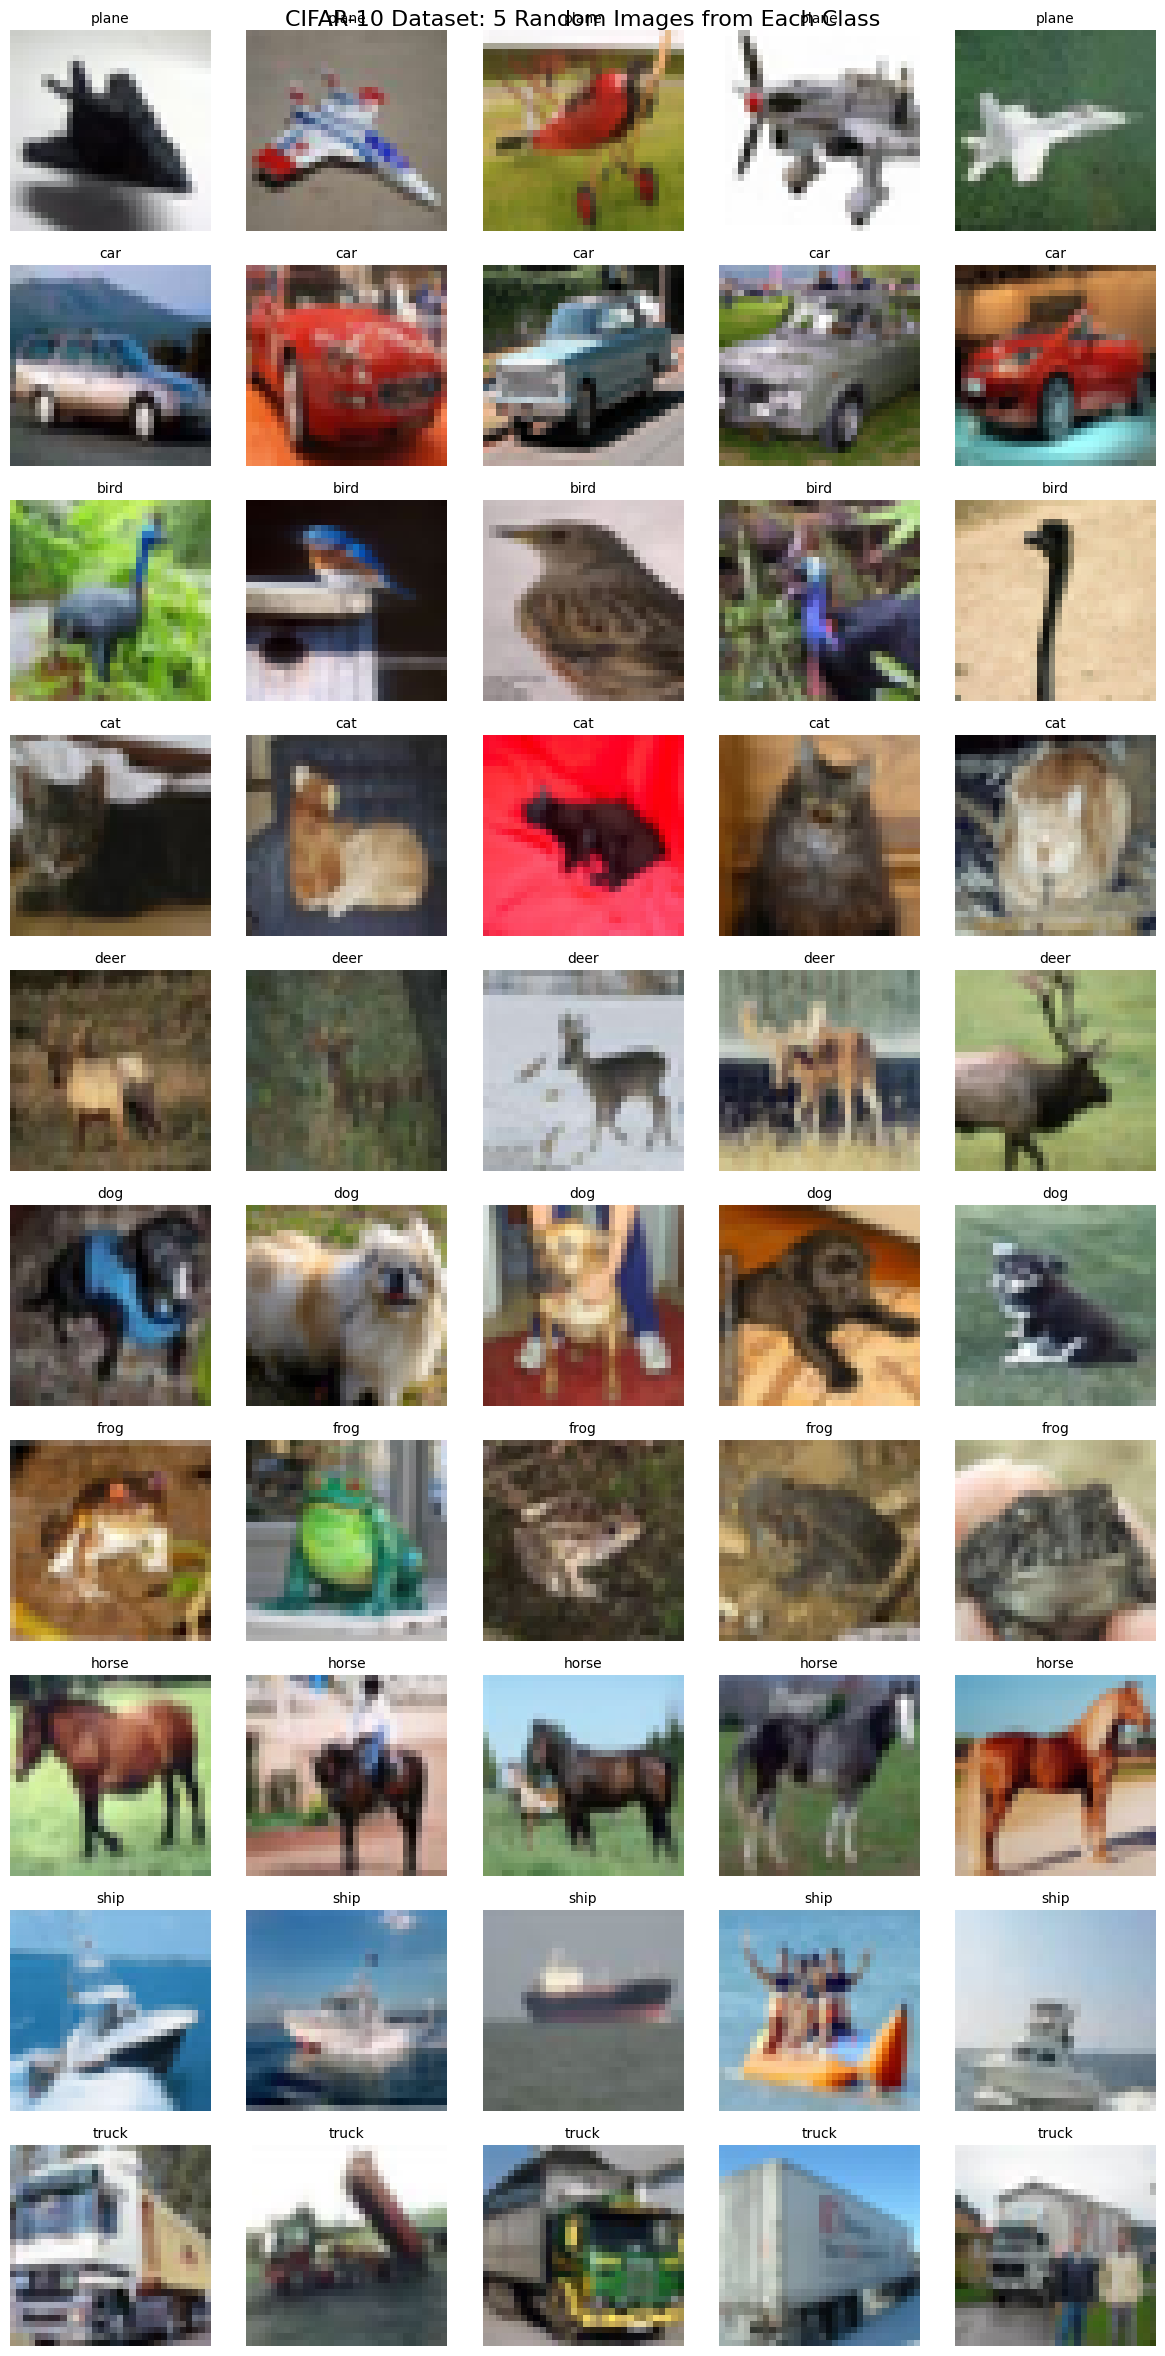

In [ ]:
def visualize_samples():
    """Visualize 5 random images from each class"""

    transform_viz = transforms.Compose([transforms.ToTensor()])
    viz_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_viz)

    class_images = {i: [] for i in range(10)}

    for idx, (image, label) in enumerate(viz_dataset):
        if len(class_images[label]) < 5:
            class_images[label].append(image)

        if all(len(images) == 5 for images in class_images.values()):
            break

    fig, axes = plt.subplots(10, 5, figsize=(12, 24))
    fig.suptitle('CIFAR-10 Dataset: 5 Random Images from Each Class', fontsize=16)

    for class_idx in range(10):
        for img_idx in range(5):
            ax = axes[class_idx, img_idx]

            image = class_images[class_idx][img_idx]
            image_np = image.permute(1, 2, 0).numpy()

            ax.imshow(image_np)
            ax.set_title(f'{classes[class_idx]}', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples()


Let's also check some statistics about our data

In [ ]:
print("\nDataset Statistics:")
print(f"Image shape: {initial_trainset[0][0].shape}")
print(f"Number of classes: {len(classes)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(trainloader)}")
print(f"Number of validation batches: {len(valloader)}")
print(f"Number of test batches: {len(testloader)}")


Dataset Statistics:
Image shape: torch.Size([3, 32, 32])
Number of classes: 10
Batch size: 512
Number of training batches: 88
Number of validation batches: 10
Number of test batches: 20


 Test the UnNormalize function

In [ ]:
print("\nTesting UnNormalize function:")
sample_batch = next(iter(trainloader))
images, labels = sample_batch
print(f"Original normalized image range: [{images[0].min():.3f}, {images[0].max():.3f}]")


Testing UnNormalize function:
Original normalized image range: [-1.988, 1.632]


In [ ]:
unnormalized_image = norminv(images[0])
print(f"Unnormalized image range: [{unnormalized_image.min():.3f}, {unnormalized_image.max():.3f}]")

Unnormalized image range: [0.000, 0.894]


# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [ ]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import math
from torchvision import transforms
import torch.nn.functional as F

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, dropout_rate=0.5):
        super(FullyConnectedNetwork, self).__init__()


        # Layer 1: 3072 -> 4096
        self.fc1 = nn.Linear(input_size, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Layer 2: 4096 -> 4096
        self.fc2 = nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer 3: 4096 -> 2048
        self.fc3 = nn.Linear(4096, 2048)
        self.bn3 = nn.BatchNorm1d(2048)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Layer 4: 2048 -> 1024
        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.dropout4 = nn.Dropout(dropout_rate)

        # Output layer: 1024 -> 10
        self.fc5 = nn.Linear(1024, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Layer 4
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        # Output layer
        x = self.fc5(x)

        return x



In [ ]:
def count_parameters(model):
    """Count the number of trainable parameters in the model"""
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [ ]:
def manual_parameter_calculation():
    """
    Manual calculation of parameters:

    For a linear layer with input_size=n and output_size=m:
    Parameters = n * m + m (weights + biases)

    For batch normalization with size n:
    Parameters = 2 * n (gamma and beta parameters)

    Our network:
    1. fc1: 3072 -> 4096 = 3072 * 4096 + 4096 = 12,582,912 + 4,096 = 12,587,008
    2. bn1: 4096 = 2 * 4096 = 8,192
    3. fc2: 4096 -> 4096 = 4096 * 4096 + 4096 = 16,777,216 + 4,096 = 16,781,312
    4. bn2: 4096 = 2 * 4096 = 8,192
    5. fc3: 4096 -> 2048 = 4096 * 2048 + 2048 = 8,388,608 + 2,048 = 8,390,656
    6. bn3: 2048 = 2 * 2048 = 4,096
    7. fc4: 2048 -> 1024 = 2048 * 1024 + 1024 = 2,097,152 + 1,024 = 2,098,176
    8. bn4: 1024 = 2 * 1024 = 2,048
    9. fc5: 1024 -> 10 = 1024 * 10 + 10 = 10,240 + 10 = 10,250

    Total = 12,587,008 + 8,192 + 16,781,312 + 8,192 + 8,390,656 + 4,096 + 2,098,176 + 2,048 + 10,250
    Total = 39,889,930 parameters
    """
    calculations = {
        'fc1': 3072 * 4096 + 4096,
        'bn1': 2 * 4096,
        'fc2': 4096 * 4096 + 4096,
        'bn2': 2 * 4096,
        'fc3': 4096 * 2048 + 2048,
        'bn3': 2 * 2048,
        'fc4': 2048 * 1024 + 1024,
        'bn4': 2 * 1024,
        'fc5': 1024 * 10 + 10
    }

    total = sum(calculations.values())

    print("Manual Parameter Calculation:")
    for layer, params in calculations.items():
        print(f"{layer}: {params:,} parameters")
    print(f"Total: {total:,} parameters")

    return total

In [ ]:
model = FullyConnectedNetwork()

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

In [ ]:
manual_params = manual_parameter_calculation()

Manual Parameter Calculation:
fc1: 12,587,008 parameters
bn1: 8,192 parameters
fc2: 16,781,312 parameters
bn2: 8,192 parameters
fc3: 8,390,656 parameters
bn3: 4,096 parameters
fc4: 2,098,176 parameters
bn4: 2,048 parameters
fc5: 10,250 parameters
Total: 39,889,930 parameters


In [ ]:
actual_params = count_parameters(model)
print(f"\nParameter Comparison:")
print(f"Manual calculation: {manual_params:,} parameters")
print(f"PyTorch count: {actual_params:,} parameters")
print(f"Difference: {abs(manual_params - actual_params):,} parameters")


Parameter Comparison:
Manual calculation: 39,889,930 parameters
PyTorch count: 39,889,930 parameters
Difference: 0 parameters


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [ ]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
       BatchNorm1d-2                 [-1, 4096]           8,192
           Dropout-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
       BatchNorm1d-5                 [-1, 4096]           8,192
           Dropout-6                 [-1, 4096]               0
            Linear-7                 [-1, 2048]       8,390,656
       BatchNorm1d-8                 [-1, 2048]           4,096
           Dropout-9                 [-1, 2048]               0
           Linear-10                 [-1, 1024]       2,098,176
      BatchNorm1d-11                 [-1, 1024]           2,048
          Dropout-12                 [-1, 1024]               0
           Linear-13                   [-1, 10]          10,250
Total params: 39,889,930
Trainable para

In [ ]:
target_min = 33_000_000
target_max = 34_000_000
print(f"\nTarget range: {target_min:,} - {target_max:,}")
print(f"Our model: {actual_params:,}")
if target_min <= actual_params <= target_max:
    print("✓ Model is within target parameter range!")
else:
    print("✗ Model is outside target parameter range. Consider adjusting architecture.")


Target range: 33,000,000 - 34,000,000
Our model: 39,889,930
✗ Model is outside target parameter range. Consider adjusting architecture.


## Train

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=60):
    """Train the model and track losses and accuracies"""
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    print("Starting training...")
    print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
    print("-" * 60)

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)

        val_loss, val_acc = validate_epoch(model, valloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        epoch_time = time.time() - start_time
        print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<12.2f} {val_loss:<12.4f} {val_acc:<12.2f} ({epoch_time:.1f}s)")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plot training history"""
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [ ]:
model = FullyConnectedNetwork()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(f"\nModel moved to device: {device}")


Model moved to device: cuda


### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
print(f"\nModel Summary:")
print(f"Total parameters: {actual_params:,}")
print(f"Model size: {actual_params * 4 / 1024 / 1024:.2f} MB (assuming 32-bit floats)")


Model Summary:
Total parameters: 39,889,930
Model size: 152.17 MB (assuming 32-bit floats)


### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import time
def train_epoch(model, trainloader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def eval_epoch(model, valloader, criterion, device):
    """Validate the model for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(valloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=60):
    """Train the model and track losses and accuracies"""
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    print("Starting training...")
    print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
    print("-" * 60)

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)

        val_loss, val_acc = eval_epoch(model, valloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        epoch_time = time.time() - start_time
        print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<12.2f} {val_loss:<12.4f} {val_acc:<12.2f} ({epoch_time:.1f}s)")

    return train_losses, train_accuracies, val_losses, val_accuracies


As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


Train The Model

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, trainloader, valloader, criterion, optimizer, device, num_epochs=60
)

Starting training...
Epoch  Train Loss   Train Acc    Val Loss     Val Acc     
------------------------------------------------------------
1      11.5126      19.76        3.7080       34.26        (11.4s)
2      6.7948       23.51        3.2586       38.86        (16.9s)
3      5.0302       26.90        2.8649       41.46        (14.0s)
4      3.6365       30.82        2.2115       42.26        (11.4s)
5      3.0023       34.59        1.9036       44.66        (11.8s)
6      2.7251       36.79        1.8891       45.72        (11.7s)
7      2.5678       38.19        1.8233       47.36        (11.8s)
8      2.3362       40.05        1.7846       48.08        (12.7s)
9      2.2527       40.93        1.7876       48.38        (11.2s)
10     2.1827       42.24        1.8001       48.00        (10.7s)
11     2.0751       42.98        1.6751       49.62        (12.0s)
12     2.0252       44.06        1.6523       50.14        (11.5s)
13     1.9387       44.93        1.6443       51.00    

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [ ]:
torch.save(model.state_dict(), "fully-connected.pth")

In [ ]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('fully-connected.pth'))

<All keys matched successfully>

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

In [ ]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plot training history"""
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

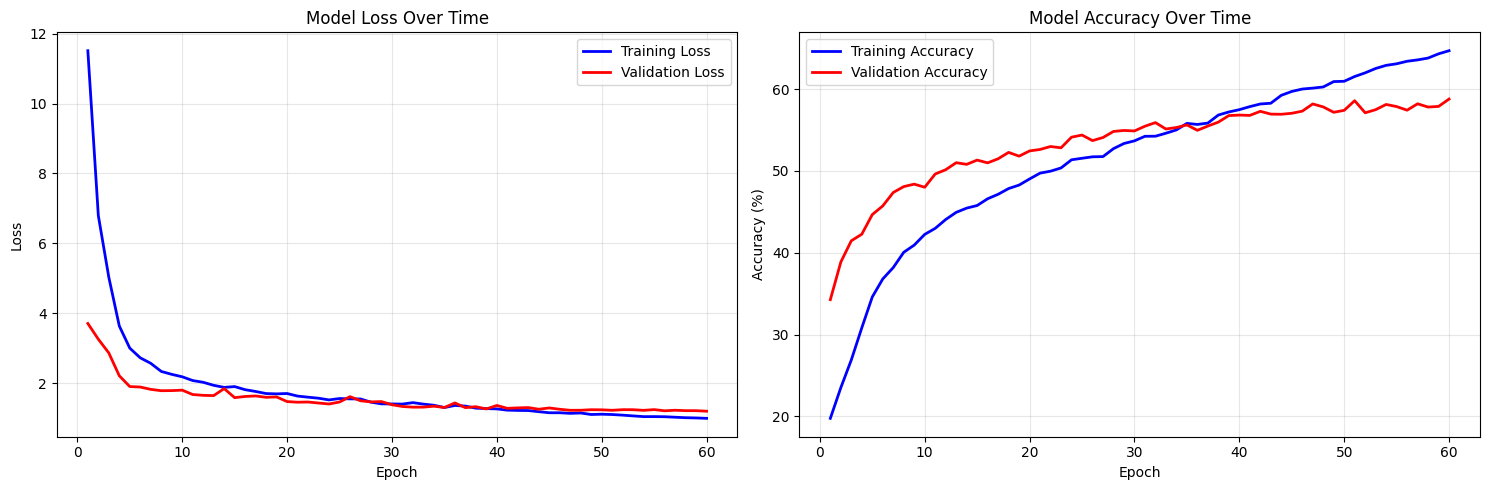

In [ ]:
plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies)

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [ ]:
def evaluate_model(model, dataloader, criterion, device, dataset_name="Test"):
    """Evaluate the model on a given dataset"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    avg_loss = running_loss / len(dataloader)
    accuracy = 100. * correct / total

    print(f"\n{dataset_name} Results:")
    print(f"{dataset_name} Loss: {avg_loss:.4f}")
    print(f"{dataset_name} Accuracy: {accuracy:.2f}% ({correct}/{total})")

    print(f"\nPer-class Accuracy:")
    for i in range(10):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f"{classes[i]}: {class_acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")

    return avg_loss, accuracy

In [ ]:
def analyze_overfitting(train_losses, train_accuracies, val_losses, val_accuracies):
    """Analyze training curves for overfitting"""
    print("\n" + "="*60)
    print("OVERFITTING ANALYSIS")
    print("="*60)

    best_val_acc_idx = np.argmax(val_accuracies)
    best_val_acc = val_accuracies[best_val_acc_idx]
    best_val_epoch = best_val_acc_idx + 1

    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    final_train_acc = train_accuracies[-1]
    final_val_acc = val_accuracies[-1]

    print(f"Best Validation Accuracy: {best_val_acc:.2f}% at epoch {best_val_epoch}")
    print(f"Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    acc_gap = final_train_acc - final_val_acc
    loss_gap = final_val_loss - final_train_loss

    print(f"\nGaps (indicators of overfitting):")
    print(f"Accuracy Gap (Train - Val): {acc_gap:.2f}%")
    print(f"Loss Gap (Val - Train): {loss_gap:.4f}")

    last_20_percent = int(0.8 * len(train_losses))
    train_loss_trend = np.mean(np.diff(train_losses[last_20_percent:]))
    val_loss_trend = np.mean(np.diff(val_losses[last_20_percent:]))

    print(f"\nTrends in final 20% of training:")
    print(f"Training Loss Trend: {'Decreasing' if train_loss_trend < 0 else 'Increasing'} ({train_loss_trend:.6f})")
    print(f"Validation Loss Trend: {'Decreasing' if val_loss_trend < 0 else 'Increasing'} ({val_loss_trend:.6f})")

    print(f"\nOVERFITTING DIAGNOSIS:")
    print("-" * 30)

    overfitting_indicators = []

    if acc_gap > 10:
        overfitting_indicators.append(f"Large accuracy gap ({acc_gap:.2f}%)")

    if loss_gap > 0.3:
        overfitting_indicators.append(f"Large loss gap ({loss_gap:.4f})")

    if train_loss_trend < -0.001 and val_loss_trend > 0.001:
        overfitting_indicators.append("Training loss decreasing while validation loss increasing")

    if final_val_acc < best_val_acc - 2:
        overfitting_indicators.append(f"Validation accuracy degraded from peak ({best_val_acc:.2f}% to {final_val_acc:.2f}%)")

    if overfitting_indicators:
        print("⚠️  OVERFITTING DETECTED!")
        print("Indicators:")
        for indicator in overfitting_indicators:
            print(f"  • {indicator}")

        print("\nRecommendations:")
        print("  • Reduce model complexity")
        print("  • Increase dropout rate")
        print("  • Add more regularization (weight decay)")
        print("  • Stop training earlier (early stopping)")
        print("  • Collect more training data")
    else:
        print("✅ NO SIGNIFICANT OVERFITTING DETECTED")
        print("The model appears to generalize well to unseen data.")

    return {
        'best_val_acc': best_val_acc,
        'best_val_epoch': best_val_epoch,
        'acc_gap': acc_gap,
        'loss_gap': loss_gap,
        'overfitting_detected': len(overfitting_indicators) > 0
    }

In [ ]:
def plot_detailed_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plot detailed training history with annotations"""
    epochs = range(1, len(train_losses) + 1)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    best_val_loss_idx = np.argmin(val_losses)
    ax1.annotate(f'Best Val Loss: {val_losses[best_val_loss_idx]:.4f}',
                xy=(best_val_loss_idx + 1, val_losses[best_val_loss_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    best_val_acc_idx = np.argmax(val_accuracies)
    ax2.annotate(f'Best Val Acc: {val_accuracies[best_val_acc_idx]:.2f}%',
                xy=(best_val_acc_idx + 1, val_accuracies[best_val_acc_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    loss_gap = np.array(val_losses) - np.array(train_losses)
    ax3.plot(epochs, loss_gap, 'g-', linewidth=2, alpha=0.8)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title('Loss Gap (Validation - Training)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss Gap')
    ax3.grid(True, alpha=0.3)
    ax3.fill_between(epochs, loss_gap, 0, where=(np.array(loss_gap) > 0),
                     color='red', alpha=0.3, label='Overfitting Region')
    ax3.legend()

    acc_gap = np.array(train_accuracies) - np.array(val_accuracies)
    ax4.plot(epochs, acc_gap, 'purple', linewidth=2, alpha=0.8)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Accuracy Gap (Training - Validation)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Gap (%)')
    ax4.grid(True, alpha=0.3)
    ax4.fill_between(epochs, acc_gap, 0, where=(np.array(acc_gap) > 0),
                     color='orange', alpha=0.3, label='Overfitting Region')
    ax4.legend()

    plt.tight_layout()
    plt.show()


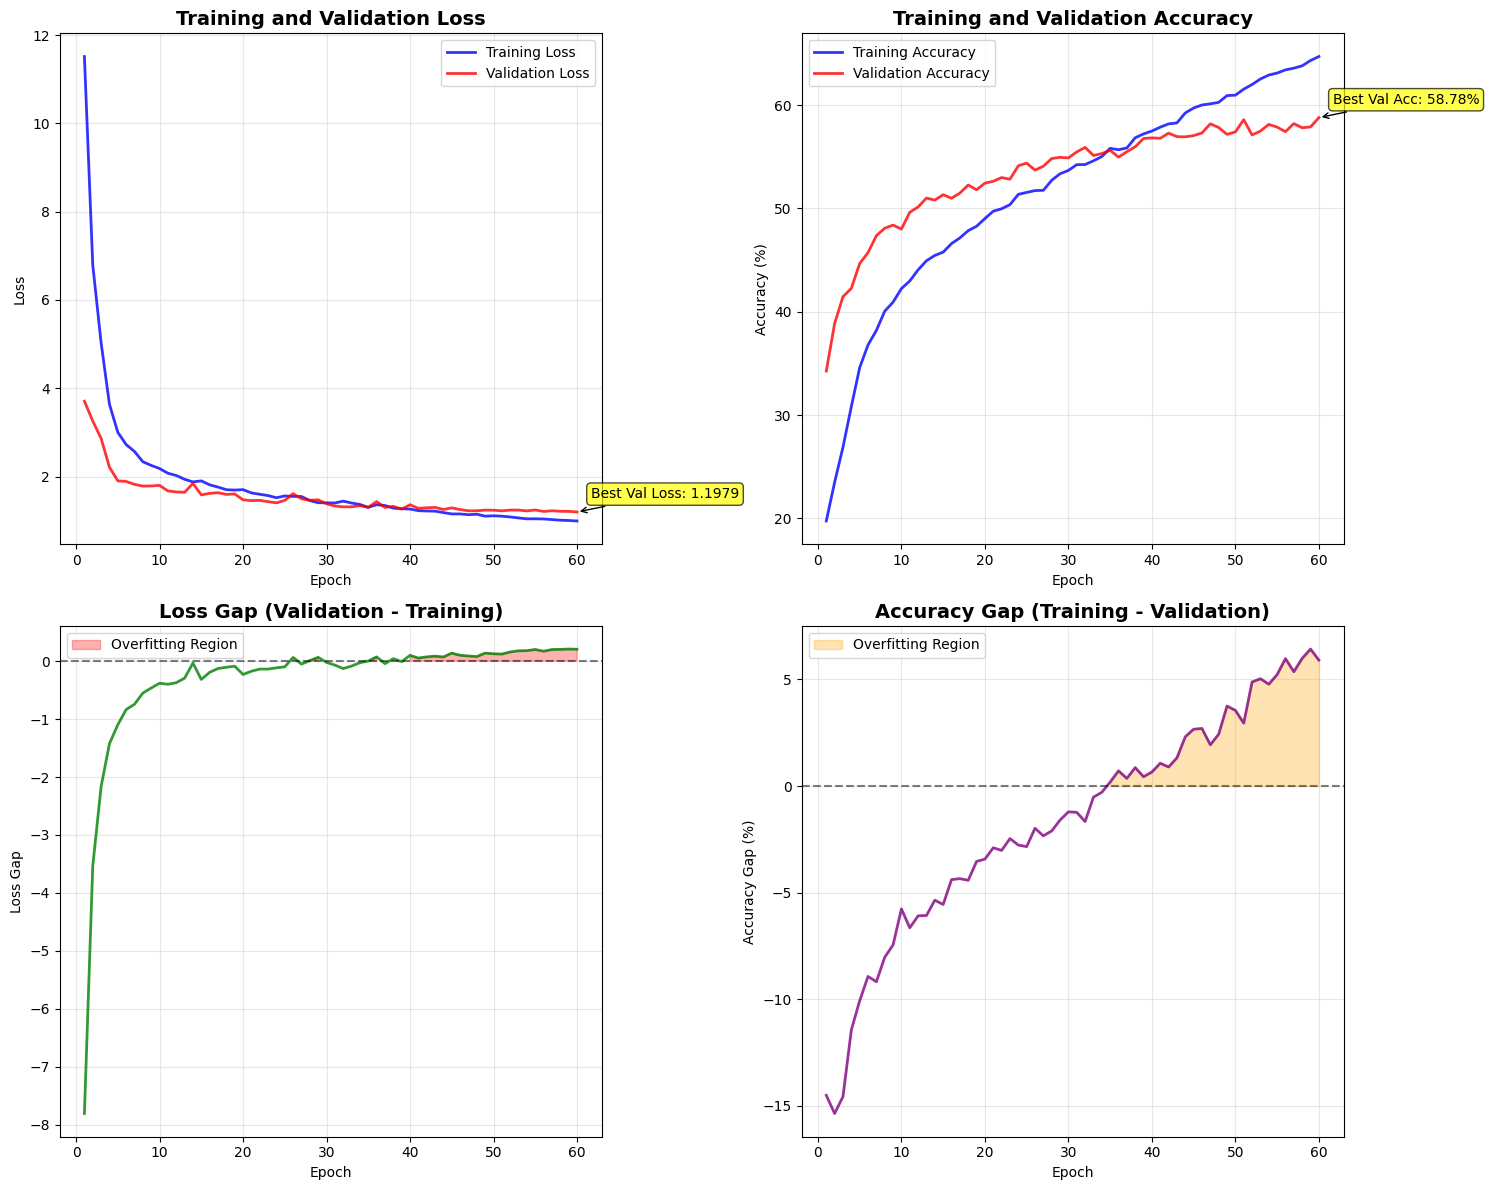

In [ ]:
plot_detailed_training_history(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
analysis_results = analyze_overfitting(train_losses, train_accuracies, val_losses, val_accuracies)


OVERFITTING ANALYSIS
Best Validation Accuracy: 58.78% at epoch 60
Final Training Accuracy: 64.69%
Final Validation Accuracy: 58.78%
Final Training Loss: 0.9939
Final Validation Loss: 1.1979

Gaps (indicators of overfitting):
Accuracy Gap (Train - Val): 5.91%
Loss Gap (Val - Train): 0.2040

Trends in final 20% of training:
Training Loss Trend: Decreasing (-0.009978)
Validation Loss Trend: Decreasing (-0.003888)

OVERFITTING DIAGNOSIS:
------------------------------
✅ NO SIGNIFICANT OVERFITTING DETECTED
The model appears to generalize well to unseen data.


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)


        self.fc1 = nn.Linear(512 * 4 * 4, 2048)
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))  # 8x8 -> 4x4
        x = F.relu(self.conv5(x))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        feature_space = self.dropout(x)
        x = self.linear(feature_space)

        return x

    def get_features(self, x):
        """Extract features from the feature space layer"""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))

        x = x.view(x.size(0), -1)
        feature_space = F.relu(self.fc1(x))

        return feature_space


In [ ]:
def test_data_and_model():
    try:
        data_iter = iter(trainloader)
        images, labels = next(data_iter)
        print(f"✓ Data loaded successfully!")
        print(f"  Batch shape: {images.shape}")
        print(f"  Labels shape: {labels.shape}")
        print(f"  Label range: {labels.min().item()} to {labels.max().item()}")
        print(f"  Image value range: {images.min().item():.3f} to {images.max().item():.3f}")

        if labels.min() < 0 or labels.max() >= 10:
            print("❌ ERROR: Labels should be in range [0, 9]")
            return False

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = CNN().to(device)

        images = images.to(device)
        with torch.no_grad():
            output = model(images)
            print(f"✓ Model forward pass successful!")
            print(f"  Output shape: {output.shape}")
            print(f"  Output range: {output.min().item():.3f} to {output.max().item():.3f}")

        return True

    except Exception as e:
        print(f"❌ ERROR in data/model test: {str(e)}")
        return False

In [ ]:
if not test_data_and_model():
    print("Please fix the data loading issues before proceeding!")
    exit()

✓ Data loaded successfully!
  Batch shape: torch.Size([512, 3, 32, 32])
  Labels shape: torch.Size([512])
  Label range: 0 to 9
  Image value range: -1.988 to 2.132
✓ Model forward pass successful!
  Output shape: torch.Size([512, 10])
  Output range: -0.042 to 0.034


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)

Using device: cuda


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 18,368,330


In [ ]:
if total_params < 33000000:
    print(f"Current model has {total_params:,} parameters, less than required 33.5M")
    print("Scaling up the model...")

    class LargeCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(LargeCNN, self).__init__()

            self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
            self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
            self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
            self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
            self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
            self.conv6 = nn.Conv2d(512, 512, 3, padding=1)

            self.pool = nn.MaxPool2d(2, 2)
            self.dropout = nn.Dropout(0.5)

            self.fc1 = nn.Linear(512 * 4 * 4, 8192)
            self.fc2 = nn.Linear(8192, 4096)
            self.linear = nn.Linear(4096, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # 32->16
            x = self.pool(F.relu(self.conv2(x)))  # 16->8
            x = F.relu(self.conv3(x))
            x = self.pool(F.relu(self.conv4(x)))  # 8->4
            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))

            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            feature_space = F.relu(self.fc2(x))  # Feature space
            x = self.dropout(feature_space)
            x = self.linear(x)

            return x

        def get_features(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = F.relu(self.conv3(x))
            x = self.pool(F.relu(self.conv4(x)))
            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))

            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            feature_space = F.relu(self.fc2(x))

            return feature_space

    model = LargeCNN().to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Updated model parameters: {total_params:,}")

Current model has 18,368,330 parameters, less than required 33.5M
Scaling up the model...
Updated model parameters: 106,987,146


`WRITE YOUR ANSWER HERE`

Once you have completed your hand calculation, you can verify your result by running the following cell:

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
            Conv2d-6            [-1, 256, 8, 8]         295,168
         MaxPool2d-7            [-1, 256, 4, 4]               0
            Conv2d-8            [-1, 512, 4, 4]       1,180,160
            Linear-9                 [-1, 2048]      16,779,264
          Dropout-10                 [-1, 2048]               0
           Linear-11                   [-1, 10]          20,490
Total params: 18,368,330
Trainable params: 18,368,330
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 106,987,146


### Criterion & Optimizer

Define `criterion` and `optimizer`

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
def train_epoch(model, criterion, optimizer, trainloader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # Debug
        if batch_idx < 3:
            print(f"    Batch {batch_idx}: Loss={loss.item():.4f}, Acc={100.*predicted.eq(target).sum().item()/target.size(0):.1f}%")

    return running_loss / len(trainloader), 100. * correct / total

def eval_epoch(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return running_loss / len(dataloader), 100. * correct / total

In [ ]:
epochs = 60
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
print("=" * 80)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")

    if val_acc > 85:
        print(f"Reached good validation accuracy ({val_acc:.2f}%), continuing training...")

Starting training...

Epoch 1/60
--------------------------------------------------
    Batch 0: Loss=1.7051, Acc=33.8%
    Batch 1: Loss=1.6803, Acc=36.5%
    Batch 2: Loss=1.7730, Acc=31.8%
Train Loss: 1.5570, Train Acc: 40.91%
Val Loss: 1.3773, Val Acc: 47.84%
Learning Rate: 0.001000

Epoch 2/60
--------------------------------------------------
    Batch 0: Loss=1.4108, Acc=44.3%
    Batch 1: Loss=1.4413, Acc=43.9%
    Batch 2: Loss=1.4452, Acc=43.9%
Train Loss: 1.2935, Train Acc: 52.17%
Val Loss: 1.1590, Val Acc: 58.32%
Learning Rate: 0.001000

Epoch 3/60
--------------------------------------------------
    Batch 0: Loss=1.1879, Acc=57.8%
    Batch 1: Loss=1.2101, Acc=56.1%
    Batch 2: Loss=1.2051, Acc=54.3%
Train Loss: 1.1051, Train Acc: 60.12%
Val Loss: 1.0442, Val Acc: 62.04%
Learning Rate: 0.001000

Epoch 4/60
--------------------------------------------------
    Batch 0: Loss=0.9550, Acc=65.0%
    Batch 1: Loss=0.9478, Acc=67.2%
    Batch 2: Loss=0.9751, Acc=65.2%
Train L

In [ ]:
print("\nEvaluating on test set...")
test_loss, test_acc = eval_epoch(model, criterion, testloader)
print(f"Test Accuracy: {test_acc:.2f}%")


Evaluating on test set...
Test Accuracy: 75.52%


### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [ ]:
import torch
torch.save(model.state_dict(), "cnn.pth")

In [ ]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('cnn.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

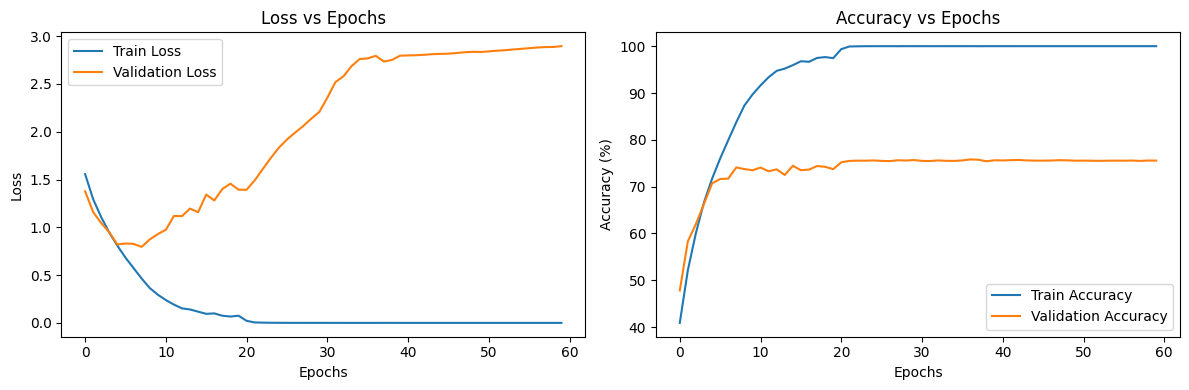

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
test_loss, test_acc = eval_epoch(model, criterion, testloader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 75.52%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

In [1]:
def unnormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Unnormalize a tensor image with mean and standard deviation.
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        mean (list): Sequence of means for each channel.
        std (list): Sequence of standard deviations for each channel.
    Returns:
        Tensor: Unnormalized image.
    """
    if torch.is_tensor(tensor):
        tensor = tensor.clone()

    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)

    tensor = tensor * std + mean

    tensor = torch.clamp(tensor, 0, 1)

    return tensor

In [2]:
def get_misclassified_samples(model, test_loader, device, num_samples=24):
    """
    Get misclassified samples from the test set.

    Args:
        model: Trained CNN model
        test_loader: DataLoader for test data
        device: Device to run inference on
        num_samples: Number of misclassified samples to collect

    Returns:
        List of tuples (image, true_label, predicted_label)
    """
    model.eval()
    misclassified_samples = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            mask = predicted != labels
            misclassified_indices = torch.where(mask)[0]

            for idx in misclassified_indices:
                if len(misclassified_samples) >= num_samples:
                    break

                img = images[idx].cpu()
                true_label = labels[idx].cpu().item()
                pred_label = predicted[idx].cpu().item()

                misclassified_samples.append((img, true_label, pred_label))

            if len(misclassified_samples) >= num_samples:
                break

    return misclassified_samples

In [3]:
def visualize_misclassified_images(misclassified_samples, num_samples=24):
    """
    Visualize misclassified images in a grid format.

    Args:
        misclassified_samples: List of (image, true_label, pred_label) tuples
        num_samples: Number of samples to visualize
    """
    if len(misclassified_samples) > num_samples:
        misclassified_samples = random.sample(misclassified_samples, num_samples)

    cols = 6
    rows = (num_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2.5))

    if rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        row = i // cols
        col = i % cols

        if i < len(misclassified_samples):
            img, true_label, pred_label = misclassified_samples[i]

            img = unnormalize_image(img, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

            img_np = img.permute(1, 2, 0).numpy()

            axes[row, col].imshow(img_np)
            axes[row, col].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                                   fontsize=10, color='red')
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.suptitle('Misclassified Images by CNN Model', fontsize=16, y=1.02)
    plt.show()

In [ ]:
misclassified_samples = get_misclassified_samples(model, test_loader, device, num_samples=24)

In [ ]:
visualize_misclassified_images(misclassified_samples, num_samples=24)

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            feature = model.get_features(data)
            features.append(feature.cpu())
            labels.append(target)

    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

train_dataset_no_shuffle = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=False, num_workers=2
)

feature_space, train_labels = extract_features(model, train_dataset_no_shuffle)
print(f"Feature space shape: {feature_space.shape}")

Feature space shape: torch.Size([45000, 4096])


### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

In [ ]:
def find_knn_in_feature_space(model, test_sample, feature_space, train_labels, k=5):
    model.eval()
    with torch.no_grad():
        test_feature = model.get_features(test_sample.unsqueeze(0).to(device)).cpu()

    distances = torch.norm(feature_space - test_feature, dim=1)
    _, indices = torch.topk(distances, k, largest=False)

    return indices, train_labels[indices]

In [ ]:
model.eval()
correct_samples = []
with torch.no_grad():
    for i, (data, target) in enumerate(testloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)

        for j in range(len(data)):
            if pred[j] == target[j] and len(correct_samples) < 5:
                correct_samples.append((data[j].cpu(), target[j].cpu(), i*len(data)+j))

        if len(correct_samples) >= 5:
            break

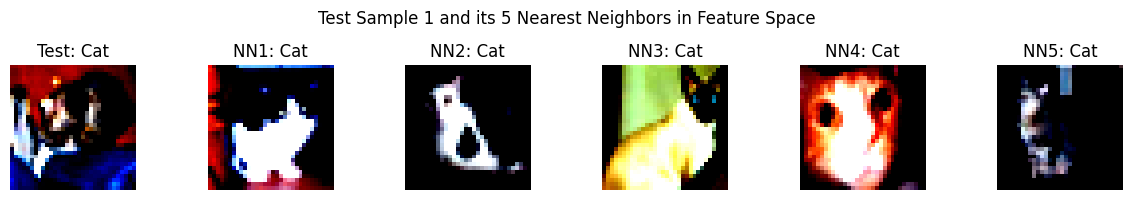

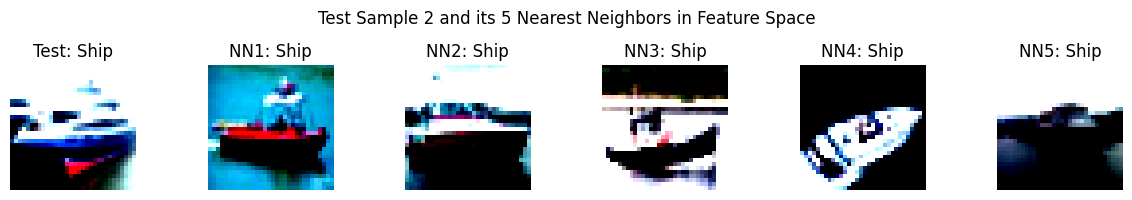

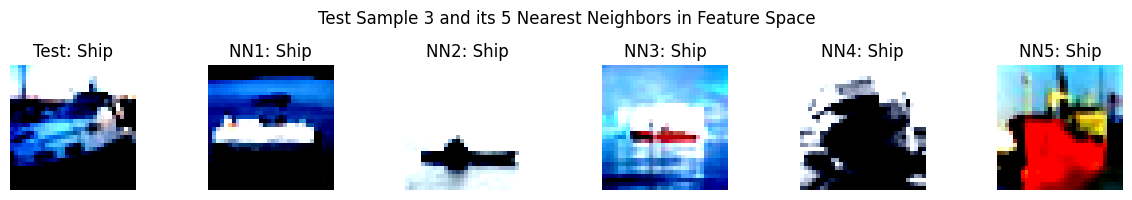

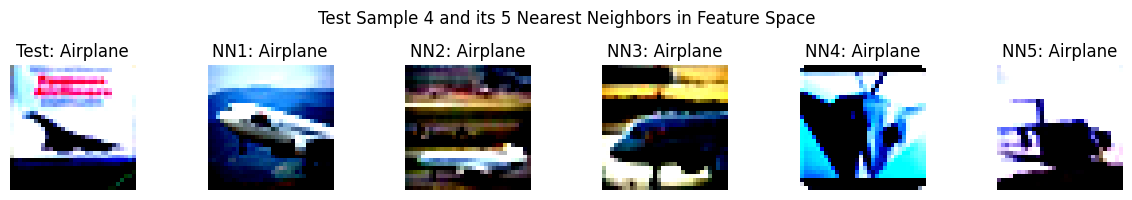

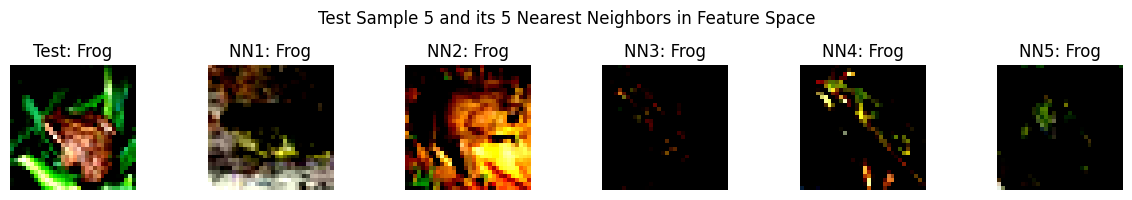

In [ ]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

for idx, (sample, true_label, sample_idx) in enumerate(correct_samples):
    knn_indices, knn_labels = find_knn_in_feature_space(model, sample, feature_space, train_labels)

    plt.figure(figsize=(12, 2))

    plt.subplot(1, 6, 1)
    plt.imshow(sample.permute(1, 2, 0))
    plt.title(f'Test: {classes[true_label]}')
    plt.axis('off')

    for i, (train_idx, neighbor_label) in enumerate(zip(knn_indices, knn_labels)):
        plt.subplot(1, 6, i+2)
        train_sample = trainset[train_idx][0]
        plt.imshow(train_sample.permute(1, 2, 0))
        plt.title(f'NN{i+1}: {classes[neighbor_label]}')
        plt.axis('off')

    plt.suptitle(f'Test Sample {idx+1} and its 5 Nearest Neighbors in Feature Space')
    plt.tight_layout()
    plt.show()

### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [ ]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
sampled_features = feature_space[indices]
sampled_labels = train_labels[indices]

tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(sampled_features.numpy())

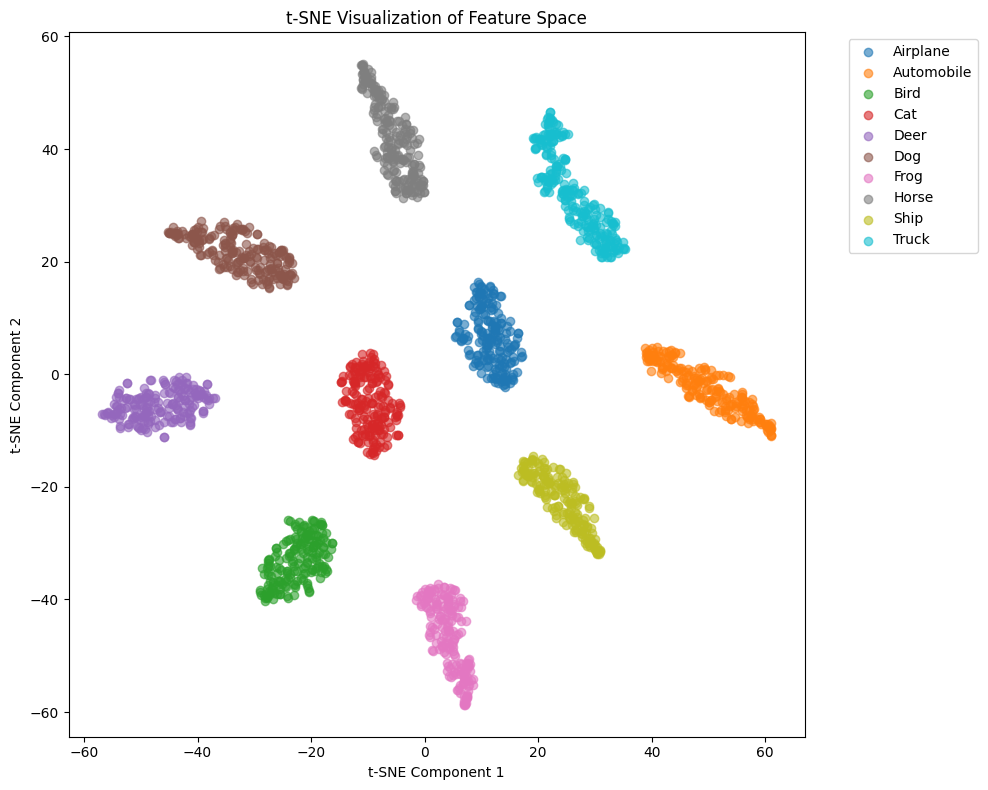

In [ ]:
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    mask = sampled_labels == i
    plt.scatter(reduced_space[mask, 0], reduced_space[mask, 1],
               c=[colors[i]], label=classes[i], alpha=0.6)

plt.title('t-SNE Visualization of Feature Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [ ]:
image = trainset[3][0].unsqueeze(0).to(device)

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [ ]:
clipped = nn.Sequential(
    model.conv1,
    nn.ReLU()
)

In [ ]:
intermediate_output = clipped(image)

In [ ]:
intermediate_output.shape

torch.Size([1, 64, 32, 32])

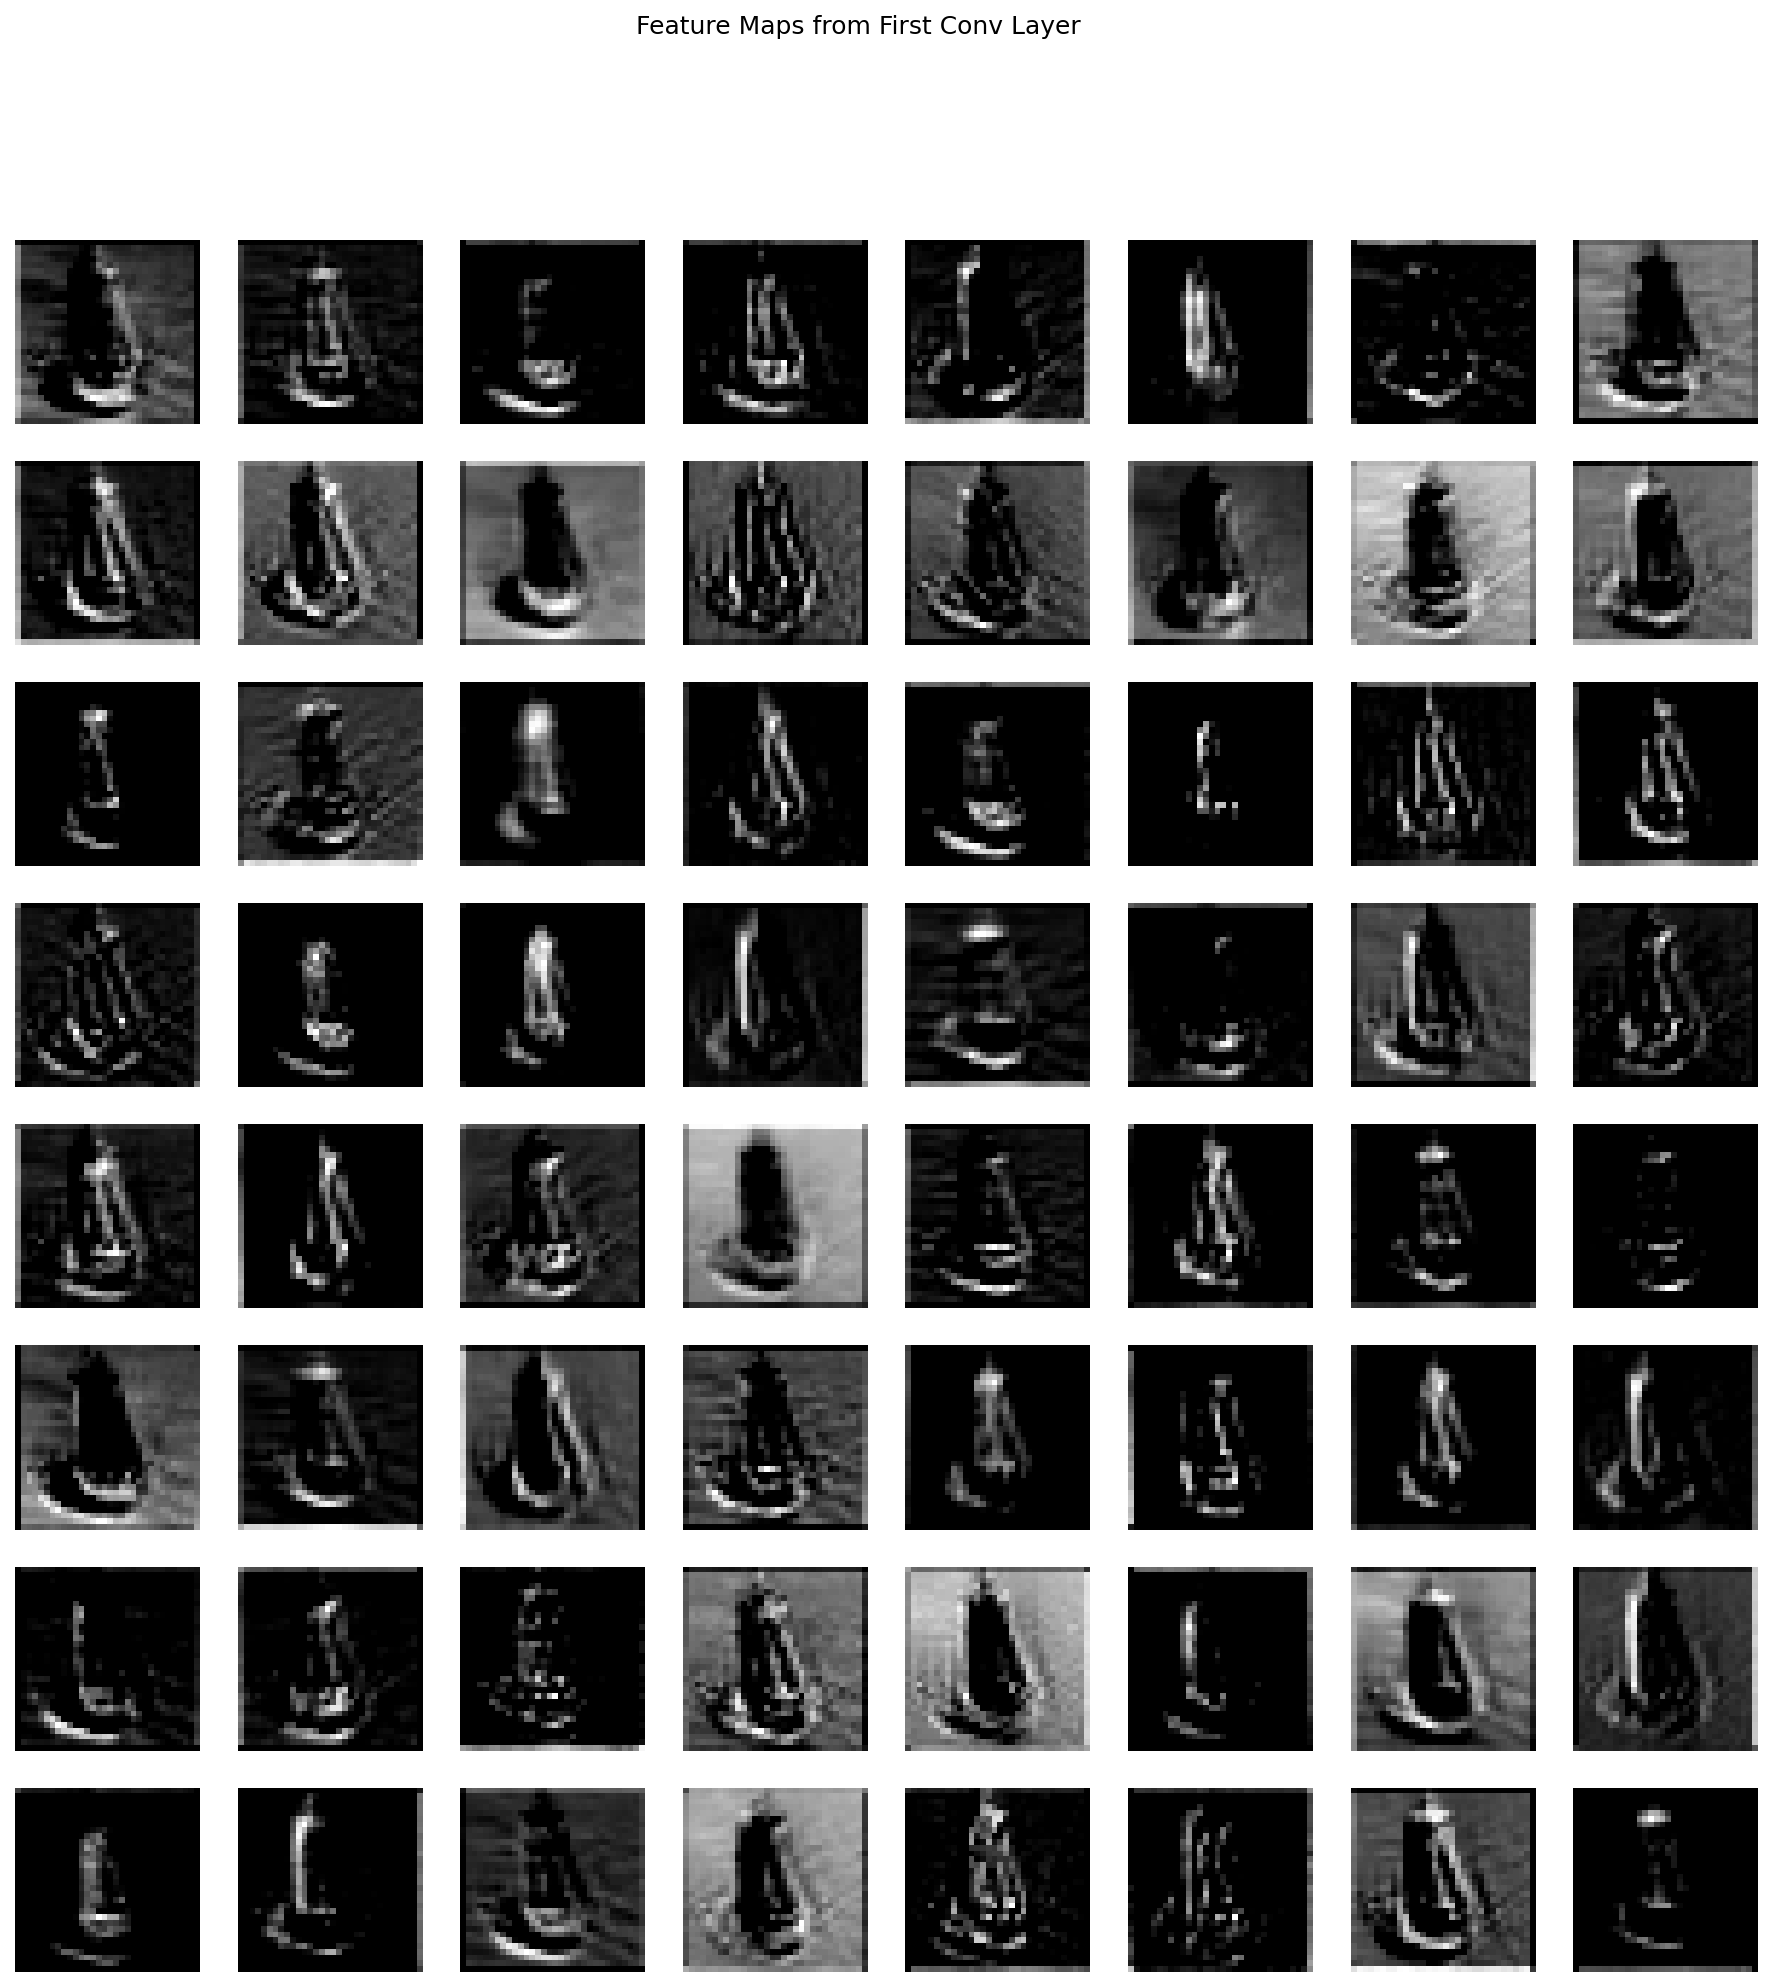

In [ ]:
import matplotlib.pyplot as plt


def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M, figsize=(15, 15))
    if title:
        fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*M + j < n_filters:
                if N > 1:
                    axs[i, j].imshow(result[0, i*M + j].cpu().detach(), cmap='gray')
                    axs[i, j].axis('off')
                else:
                    axs[j].imshow(result[0, i*M + j].cpu().detach(), cmap='gray')
                    axs[j].axis('off')
            else:
                if N > 1:
                    axs[i, j].axis('off')
                else:
                    axs[j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps from First Conv Layer')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
